# U-Net Training Example Notebook
#### UCSD/SDSC June 9, 2019
##### Author: Dylan Uys

This notebook provides a basic example of training a U-Net for LV CMR segmentation

In [19]:
from py_unet.utils.data_utils import get_split_dirs
from py_unet.data_generator import DataGenerator

In [4]:
data_dirs = ['/Users/duys/proj/ucsd-medical/data/mice_176_patient_dirs_111_npy/']
split = [0.74, 0.15, 0.11]

train_dirs, val_dirs, test_dirs = get_split_dirs(data_dirs, split=split)

104 Patients, 2062.0 Samples
72 patients for training (1542.0 samples, 74.78% of 2062.0)
18 patients for validation (324.0 samples, 15.71% of 2062.0)
14 patients for testing (196.0 samples, 9.51% of 2062.0)


### Create a `DataGenerator` for each partition

    
* At a minimum, you must set the `directories` argument (but you probably also want to set `batch_size` and `image_dims`)
    * Rather than loading all images and masks at once, the generator will store absolute filepaths to all the images it finds in `directories`
    
   
* This class is compatible with `fit_generator` and `predict_generator` in Keras
    * These methods use `__getitem__` and `__len__` to interact with the generator, which inherits from `Keras.utils.Sequence`
        * `__len__` corresponds to the number of batches in the generator (there's also the `n_samples` property for convenience) 
        * When `__getitem__` is invoked, a batch of images and masks are loaded 
            * These will be Numpy matrices with shape `(batch, image_dims[0], image_dims[1], 1)`
        * `on_epoch_end` is another piece of Keras functionality, which this class uses to shuffle the filenames after every training epoch




    

Finished loading: 385 batches, 1542 samples
Finished loading: 81 batches, 324 samples
Finished loading: 49 batches, 196 samples


<Figure size 432x288 with 0 Axes>

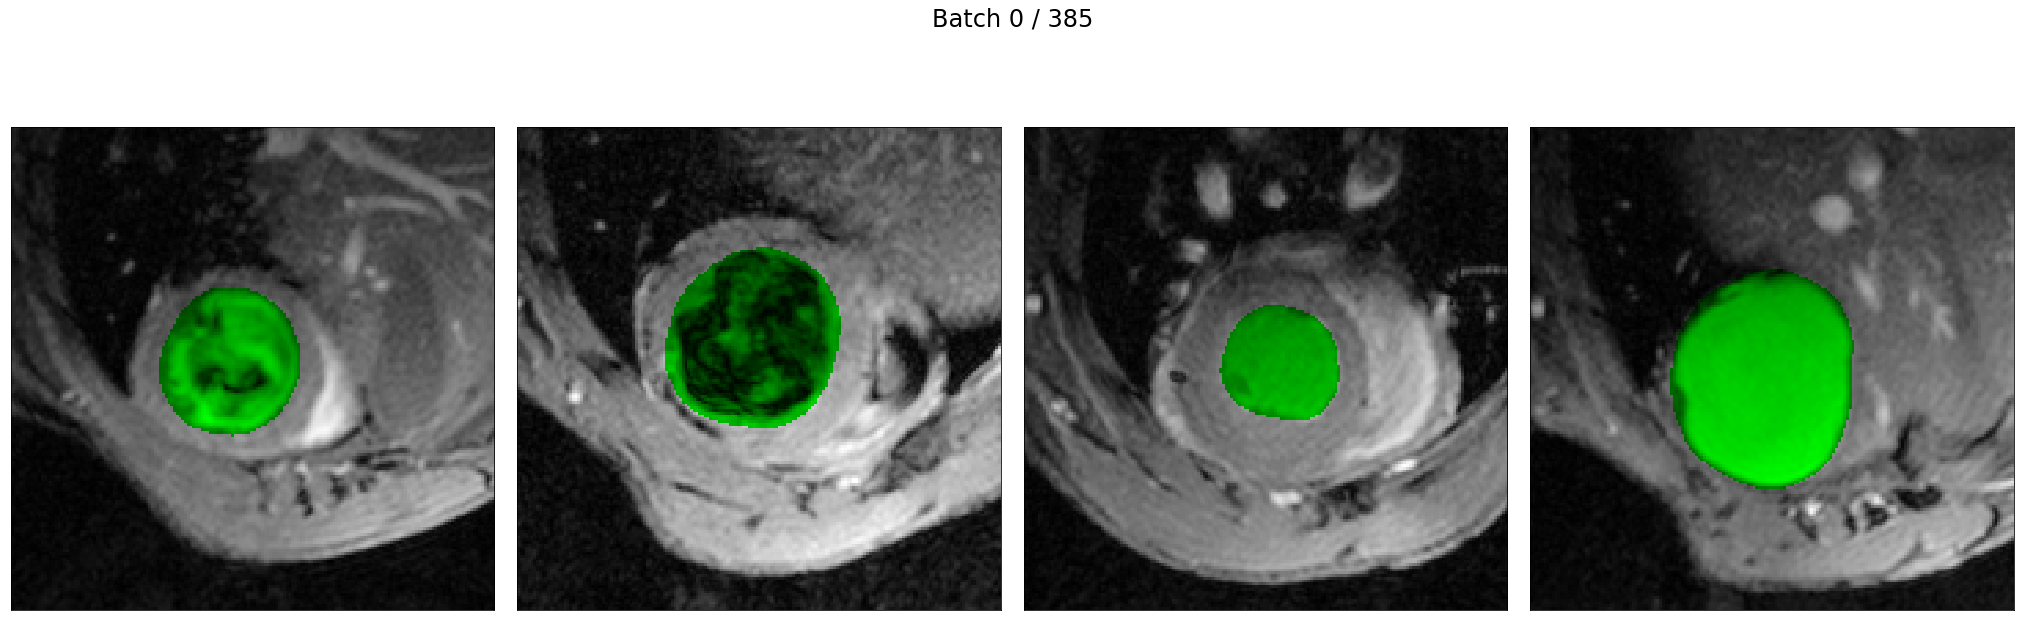

In [5]:
image_dims = (176, 176)
batch_size = 4

train_gen = DataGenerator(train_dirs, batch_size, image_dims)
val_gen = DataGenerator(val_dirs, batch_size, image_dims)
test_gen = DataGenerator(test_dirs, batch_size, image_dims)

# Inspect a batch to make sure we didn't screw up
train_gen.show_batch(0)

In [6]:
from keras.optimizers import Adam

from py_unet.unet_builder import UnetBuilder
from py_unet.utils.metric_utils import bce_dice_loss, dice_coef
from py_unet import ModelMGPU, device_config

### Make the tensorflow backend aware of compute devices 

* `py_unet`.`device_utils`.`device_config` uses tensorflow library functions to find available compute devices, and returns the number of available GPUs
* If GPUs are available, Keras is made aware of this by setting the `CUDA_VISIBLE_DEVICES` environment variable
* More on multi-gpu stuff below...


In [7]:
n_gpus = device_config(verbose=True)

print('\n{} GPUs found'.format(n_gpus))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18225942796367494018
]

0 GPUs found


### Configure a  `UnetBuilder`  to match your desired architecture


Importat arguments:
* `input_dim`: This should be (rows, cols, channels), corresponding to the Keras backend setting `data_format='channels_last'`
* `ds_filter_counts`: Number of convolutional filters to use for layers in each block of the U-net's contracting bath. 

    For example, [8, 16, 32, 64, 128]  will build a U-Net with 9 blocks, where 
       ds_filter_counts[:-1] corresponds to a 4 block contracting path,
       ds_filter_counts[-1] corresponds to the bottleneck block, and 
       ds_filter_counts[::-1]  corresponds to a 4 block expanding path.
       
* `n_gpus`: The model will be parallelized to this many GPUs if > 1, otherwise, no action is taken.
    * To see how simple Keras makes this, see `py_unet`.`utils`.`device_utils` for the `ModelMGPU` class


* See `unet_builder.py` for more options like `dropout`, `batch_norm`, etc. 




    

In [8]:
input_dim = image_dims + (1,)
ds_filter_counts = [8, 16, 32, 64, 128] # [64, 128, 256, 512, 1024]
dropout = True 

model_builder = UnetBuilder(input_dim, 
                            ds_filter_counts, 
                            dropout=dropout,
                            n_gpus=n_gpus)

### Build and compile your model

* Here, you can simply call yourUnetBuilderInstance.`build()` to get a model. 
* Then, compile it with the desired optimizer, loss and metrics. 

* Note that if `n_gpus` > 1, this model will be an instance of the `ModelMGPU` class
    * This hides away your model's actual layers
    * If you want to get your original model (for saving or whatever), pass this model as an argument to `get_inner_model` (found in  `py_unet`.`utils`.`model_utils`)



In [9]:
model = model_builder.build()

model.compile(optimizer=Adam(lr=0.0005), 
              loss=bce_dice_loss,  
              metrics=[bce_dice_loss, dice_coef])

## 3) Train or Load State

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from py_unet.utils.model_utils import load_model_state, save_model_state
from py_unet.utils.plot_utils import plot_train_histories

In [11]:
train = False

### Option 1: Load the weights and optimizer of a trained model

* There are multiple ways to load a trained model, but since we use a custom loss function, we're limited to just a couple. 
* We already built and compiled a model, so we'll simply load the weights and optimizer state of a previously saved model.
    * This can be accomplished by calling `load_model_state` 
    * The model whose weights/optimizer you load must have the same architectural configuration as the model you defined
* If you want to instead load a whole model including it's architecture, see `load_model` (both functions defined in `py_unet`.`utils`.`model_utils`)

In [12]:
if not train:
    trained_model_name = 'vis_best_1'
    models_dir = 'trained_models'

    model = load_model_state(model, trained_model_name, models_dir)

In [18]:
from py_unet.utils.model_utils import save_model

save_model(model, '1a_full', models_dir)

### Option 2: Train your model


In [31]:
if train:
    callbacks = [
        EarlyStopping(monitor='val_bce_dice_loss', mode='min',
                      patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                          verbose=1, mode='auto', min_delta=0.0001)
    ]
    
    start_time = datetime.now()
    train_history = model.fit_generator(train_gen,
                                        epochs=epochs,
                                        validation_data=val_gen,
                                        callbacks=callbacks)
    train_time = datetime.now() - start_time
    
    # Display training time and dice/loss curves
    print('Training took {} seconds'.format(train_time.total_seconds()))
    plot_train_histories(train_history, ['dice_coef', 'loss']) 

## 4) Evaluate your model

In [32]:
from py_unet.utils.eval_utils import evaluate_model
from py_unet.utils.plot_utils import plot_dice, display_pred_comparison

In [33]:
results = evaluate_model(model, test_gen.load_all(), sort_results=True)

	precision: 0.9743408714722606
	recall: 0.9686779240835194
	dice: 0.9715011469739947
	Predict time (s): 12.435699


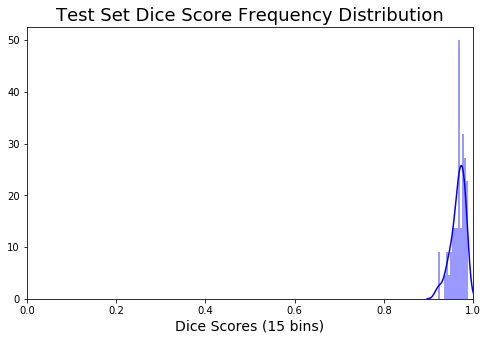

In [34]:
plot_dice(results['dice_scores'], bins=15)

0.9201195674957553


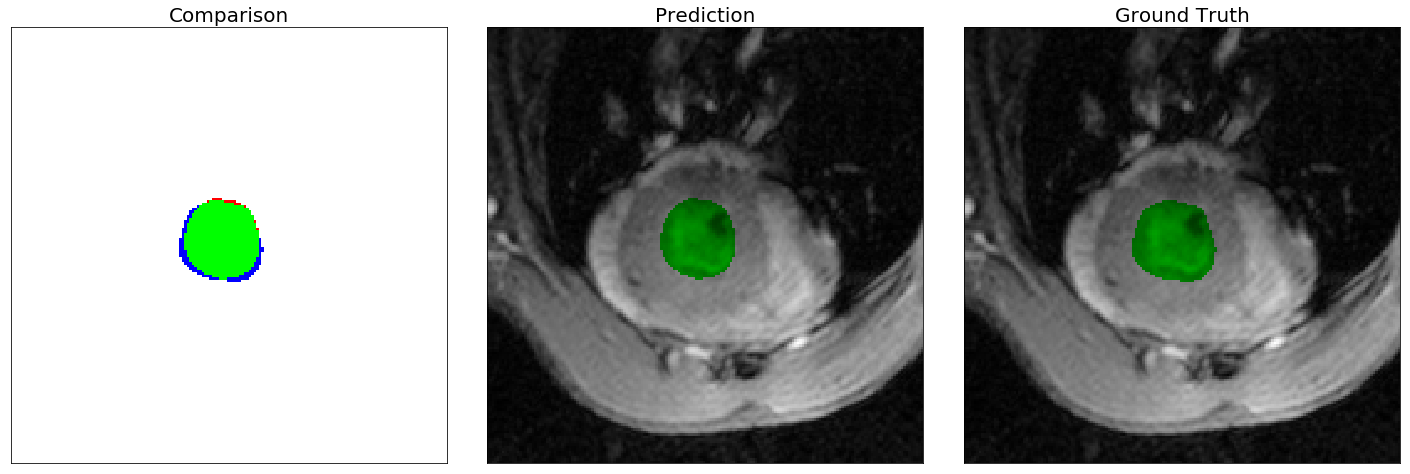

In [38]:
i = 0
print(results['dice_scores'][i])
display_pred_comparison(results['Y'][i], results['predictions'][i], results['X'][i]);

In [40]:
save_model_state(model, 'wow_cool', 'trained_models')

In [41]:
!ls trained_models

m_33M-0_pruned.json             pruned.json
optimizer_bigboi.pkl            weights_bigboi.h5
optimizer_m_33M-0_pruned.pkl    weights_m_33M-0_pruned.h5
optimizer_pruned.pkl            weights_pruned.h5
optimizer_pruned_vis_best_1.pkl weights_pruned_vis_best_1.h5
optimizer_vis_best_1.pkl        weights_vis_best_1.h5
optimizer_wow_cool.pkl          weights_wow_cool.h5
